# NST Experminets Notebook!

This notebook has been tested on google colab.

### Sections:
1. Test Gatys NST implementation with a single pair of content and style images.
2. Test the EvaluationMetrics classs with the generted image.
3. Test the implementation of Gatys NST to perform a collection style trasnger. (NOT WORKING!)


### Note: Make sure you have the Eval_data.zip file in your directory.

In [1]:
# Run this cell for google colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
# Make sure the directory below matches with yours.
%cd /content/drive/MyDrive/cs7643/project/cs7643-project
%ls

/content/drive/MyDrive/cs7643/project/cs7643-project
 collection_style_transfer.py   fcn.py                        PerceptualSimilarity/
 CycleGAN.ipynb                 LICENSE                       __pycache__/
 download_cyclegan_dataset.sh   module.py                     README.md
 Eval/                          multi_style_transfer.py       style_transfer.py
 Eval_data.zip                  nst_experiments.ipyn          testing_data/
 eval_metrics.py               'old_style_transfer copy.py'


In [4]:
# Uncomment this line if you need to unzip the eval_data.
#!unzip Eval_data.zip

## Making Sure the Scripts Work Correcly

We are going to test NST implementation for normal style transfer.

In [5]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from style_transfer import StyleTransfer

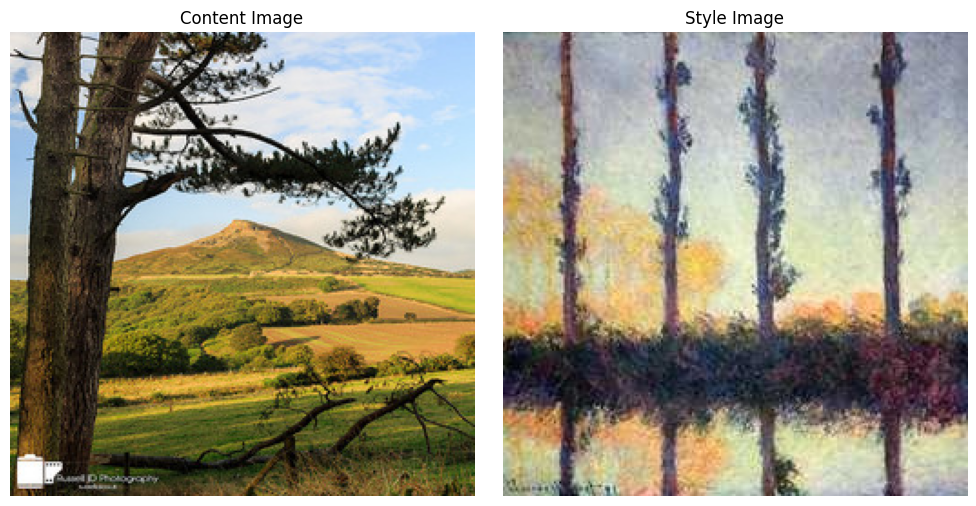

In [12]:
# File paths for the content and style images
# content_img_path = "./testing_data/images/dancing.jpg"
# style_img_path = "./testing_data/images/picasso.jpg"

content_img_path = "./testing_data/images/tree.png"
style_img_path = "./testing_data/images/monet.jpg"

# Load the content and style images using matplotlib.image
content_img = mpimg.imread(content_img_path)
style_img = mpimg.imread(style_img_path)

# Create subplots for displaying the images side by side
plt.figure(figsize=(10, 5))

# Plot the content image on the left subplot
plt.subplot(1, 2, 1)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')  # Turn off axis labels

# Plot the style image on the right subplot
plt.subplot(1, 2, 2)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')  # Turn off axis labels

# Show the plots
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Building the style transfer model..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 37.575394 Content Loss: 11.484152

run [100]:
Style Loss : 14.980794 Content Loss: 9.375427

run [150]:
Style Loss : 10.276504 Content Loss: 7.537799

run [200]:
Style Loss : 7.370621 Content Loss: 6.613865

run [250]:
Style Loss : 5.492490 Content Loss: 6.134980

run [300]:
Style Loss : 4.170516 Content Loss: 5.811624



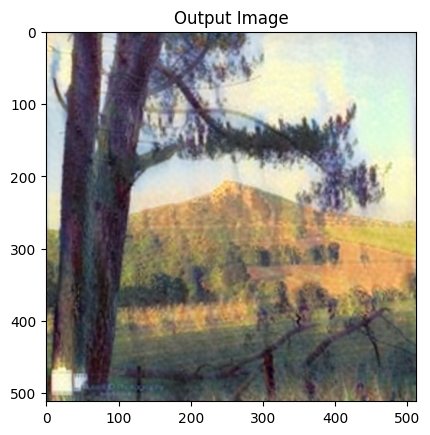

In [7]:
# Create an instance of the style transfer class with the paths to your images
style_transfer = StyleTransfer(content_img_path, style_img_path)

# Run the style transfer
output = style_transfer.run_style_transfer(style_transfer.content_img, style_transfer.style_img, style_transfer.content_img.clone())

# Display the output
StyleTransfer.imshow(output, title='Output Image')

# Show the plot in the notebook
plt.show()

# Save the resulting image to a file
style_transfer.save_output_image(output, "./testing_data/images/output_monet.jpg")


## Testing Evaluation Metrics

Here we will make sure that the implementation of all evaluation metrics is working

In [8]:
# Dependencies
!pip install pytorch-fid
!pip install lpips

In [13]:
# Import libraries and modules
from eval_metrics import EvaluationMetrics

In [14]:
eval_metrics = EvaluationMetrics(device='cuda')

# Input the correct file paths
generated_image_path = './testing_data/images/output_monet.jpg'   # This is the output of the model. AKA the generated image.

# Compute SSIM
ssim_score = eval_metrics.compute_ssim(content_image_path, generated_image_path)
print(f'SSIM: {ssim_score}')

# Compute PSNR
psnr_score = eval_metrics.compute_psnr(content_image_path, generated_image_path)
print(f'PSNR: {psnr_score}')

# Preprocess the images for feature-based similarity and LPIPS
content_tensor = eval_metrics.preprocess_image(content_image_path)
generated_tensor = eval_metrics.preprocess_image(generated_image_path)

# Compute feature-based similarity
feature_similarity = eval_metrics.compute_feature_similarity(content_tensor, generated_tensor)
print(f'Feature-based similarity (cosine): {feature_similarity}')

# Compute LPIPS and ArtFID
lpips_score, art_fid_score = eval_metrics.compute_lpips_and_artFID(content_tensor, generated_tensor)
print(f'LPIPS: {lpips_score}')
print(f'ArtFID:{art_fid_score}')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
SSIM: 0.24671035148355297
PSNR: 7.724095071644114
Feature-based similarity (cosine): 0.2443183958530426
LPIPS: 0.7578891515731812
ArtFID:9.635071952760368


In [27]:
# Note: this is compute over all the style collection and output collection
# Compute FID
#!python -m pytorch_fid "./testing_data/images/picasso.jpg" './testing_data/images/output.jpg' --dims 192

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_fid/__main__.py", line 3, in <module>
    pytorch_fid.fid_score.main()
  File "/usr/local/lib/python3.10/dist-packages/pytorch_fid/fid_score.py", line 313, in main
    fid_value = calculate_fid_given_paths(args.path,
  File "/usr/local/lib/python3.10/dist-packages/pytorch_fid/fid_score.py", line 259, in calculate_fid_given_paths
    m1, s1 = compute_statistics_of_path(paths[0], model, batch_size,
  File "/usr/local/lib/python3.10/dist-packages/pytorch_fid/fid_score.py", line 243, in compute_statistics_of_path
    m, s = calculate_activation_statistics(files, model, batch_size,
  File "/usr/local/lib/python3.10/dist-packages/pytorch_fid/fid_score.py", line 228, in calculate_activation_statisti

## Making Sure the Collection Style Transfer Works

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import copy
import torch.nn.functional as F

class GatysNSTCollection:
    def __init__(self, style_images, content_image, image_size=(128, 128), num_steps=300, style_weight=1e6, content_weight=1):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])
        self.content_image = self.image_loader(content_image)
        self.style_images = [self.image_loader(image) for image in style_images]
        self.num_steps = num_steps
        self.style_weight = style_weight
        self.content_weight = content_weight
        self.model = self.get_model()
        self.style_grams = self.get_style_grams()

    def image_loader(self, image_name):
        image = Image.open(image_name)
        image = self.transform(image).unsqueeze(0)
        return image.to(self.device, torch.float)

    def get_model(self):
        cnn = models.vgg19(pretrained=True).features.to(self.device).eval()
        cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(self.device)
        cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(self.device)

        # Create a module to normalize input image so we can easily put it in a nn.Sequential
        class Normalization(nn.Module):
            def __init__(self, mean, std):
                super(Normalization, self).__init__()
                # .view the mean and std to make them [C x 1 x 1] so that they can directly work with image Tensor of shape [B x C x H x W].
                self.mean = torch.tensor(mean).view(-1, 1, 1)
                self.std = torch.tensor(std).view(-1, 1, 1)

            def forward(self, img):
                # normalize img
                return (img - self.mean) / self.std

        normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(self.device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_layers = ['conv_4']
        style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}_'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}_'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}_'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}_'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(self.content_image).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}_".format(i), content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(self.style_image).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}_".format(i), style_loss)

        # now we trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model

#

    def get_features(self, image, model):
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # content representation
            '28': 'conv5_1'
        }
        features = {}
        x = image
        for name, layer in model._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
        return features

    def gram_matrix(self, input):
        _, d, h, w = input.size()
        tensor = input.view(d, h * w)
        gram = torch.mm(tensor, tensor.t())
        return gram.div(d * h * w)

    def transfer_style(self):
        """ Run the style transfer. """
        input_img = self.content_image.clone()
        optimizer = optim.LBFGS([input_img.requires_grad_()])

        run = [0]
        while run[0] <= self.num_steps:

            def closure():
                # correct the values of updated input image
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()
                model_output = self.model(input_img)
                style_score = 0
                content_score = 0

                for sl in model_output['style']:
                    style_score += sl.loss
                for cl in model_output['content']:
                    content_score += cl.loss

                style_score *= self.style_weight
                content_score *= self.content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()
        self.loss = F.mse_loss(self.target, self.target)

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()
        self.loss = F.mse_loss(self.target, self.target)

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

    def gram_matrix(self, input):
        batch, channels, height, width = input.size()
        features = input.view(batch * channels, height * width)
        G = torch.mm(features, features.t())
        return G.div(batch * channels * height * width)


In [5]:
import os
import glob

# Directory path where your images are stored
image_folder = "./Eval/style_images_small"

# Use glob to get a list of all image files in the folder
image_files = glob.glob(os.path.join(image_folder, "*.jpg"))

# Create an empty list to store the image paths
image_paths = []

# Loop through the image files and add them to the list
for image_file in image_files:
    image_paths.append(image_file)

# Now you have a list of image paths in the 'image_paths' variable
# You can pass this list to your style transfer model


In [7]:
len(image_paths)

['./Eval/style_images_small/Copy of 01233.jpg', './Eval/style_images_small/Copy of 00304.jpg', './Eval/style_images_small/Copy of 00457.jpg', './Eval/style_images_small/Copy of 00819.jpg', './Eval/style_images_small/Copy of 00923.jpg', './Eval/style_images_small/Copy of 00696.jpg', './Eval/style_images_small/Copy of 00481.jpg', './Eval/style_images_small/Copy of 00775.jpg', './Eval/style_images_small/Copy of 00469.jpg', './Eval/style_images_small/Copy of 00837.jpg']


In [8]:
# Assuming the GatysNSTCollection class is already defined above or imported
# Let's say you have the following image paths
content_image_path = '/content/drive/MyDrive/cs7643/project/cs7643-project/Eval/content_images/2014-08-02 11:46:18_real.png'
style_images_paths = image_paths

# Instantiate the class with your images
nst = GatysNSTCollection(style_images=style_images_paths, content_image=content_image_path)

# Perform the style transfer
output_image = nst.transfer_style()

# Save the output image or display it
output_image_path = 'path_to_save_output_image.jpg'
output_image_pil = transforms.ToPILImage()(output_image.squeeze(0).cpu())
#output_image_pil.save(output_image_path)

# If you want to display the image in a notebook environment, you can do:
import matplotlib.pyplot as plt

plt.imshow(output_image_pil)
plt.axis('off')  # to hide the axis labels
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-40bf96153833>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-4-40bf96153833>:40: UserWarning: To copy construct from a tensor, it is recommended to us

IndexError: ignored